In [1]:
#import packages and functions
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import os
import fiona

import shapely
from shapely.validation import make_valid


In [2]:
from general_functions import *

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
#define relative paths
waterschap = 'HHSK'
path_HHSK = '..\..\Data_preprocessed\Waterschappen\HHSK\HyDamo_metWasverzachter_20230905.gpkg'
output_gpkg_path = "../../Data_postprocessed/Waterschappen/HHSK"


In [5]:
HHSK = read_gpkg_layers(gpkg_path = path_HHSK, 
                                  variables = ['stuw', 
                                               'gemaal', 
                                               'afsluitmiddel',
                                               'duikersifonhevel',
                                               'hydroobject',
                                               # 'peilgebiedvigerend',
                                               # 'peilafwijkinggebied',
                                               # 'peilbesluitgebied',
                                               'streefpeil'],
                                 engine = 'pyogrio') 
                                     

In [6]:
HHSK_nalevering = read_gpkg_layers(gpkg_path = r"D:\Users\Bruijns\Documents\PR4750_20\Data_preprocessed\Waterschappen\HHSK\LHM_hhsk_nalevering.gpkg",
                                   variables = ['Persleiding'])

In [7]:
HHSK_2nalevering = read_gpkg_layers(gpkg_path = r"D:\Users\Bruijns\Documents\PR4750_20\Data_preprocessed\Waterschappen\HHSK\hhsklevering_07032024.gpkg",
                                   variables = ['PeilgebiedPraktijk',
                                                'VigerendPeilgebiedZPP'])

## Only select status_object == 3

In [8]:
HHSK['stuw'] = HHSK['stuw'].loc[(HHSK['stuw']['statusobject'] == '3') | (HHSK['stuw']['statusobject'] == 3)]
HHSK['gemaal'] = HHSK['gemaal'].loc[(HHSK['gemaal']['statusobject'] == '3') | (HHSK['gemaal']['statusobject'] == 3)]
HHSK['hydroobject'] = HHSK['hydroobject'].loc[(HHSK['hydroobject']['statusobject'] == '3') | (HHSK['hydroobject']['statusobject'] == 3)]
HHSK['duikersifonhevel'] = HHSK['duikersifonhevel'].loc[(HHSK['duikersifonhevel']['statusobject'] == '3') | (HHSK['duikersifonhevel']['statusobject'] == 3)]
HHSK['afsluitmiddel'] = HHSK['afsluitmiddel'].loc[(HHSK['afsluitmiddel']['statusobject'] == '3') | (HHSK['afsluitmiddel']['statusobject'] == 3)]

# HHSK['peilgebiedvigerend'] = HHSK['peilgebiedvigerend'].loc[(HHSK['peilgebiedvigerend']['statusobject'] == '3') | (HHSK['peilgebiedvigerend']['statusobject'] == 3)]
# HHSK['peilafwijkinggebied'] = HHSK['peilafwijkinggebied'].loc[(HHSK['peilafwijkinggebied']['statusobject'] == '3') | (HHSK['peilafwijkinggebied']['statusobject'] == 3)]

HHSK_nalevering['Persleiding'] = HHSK_nalevering['Persleiding'].loc[(HHSK_nalevering['Persleiding']['STATUSOBJECT'] == '3') | (HHSK_nalevering['Persleiding']['STATUSOBJECT'] == 3)]

In [9]:
HHSK['hydroobject']['categorieoppwaterlichaam'] = HHSK['hydroobject']['categorieoppwaterlichaam'].astype(float)
HHSK['hydroobject'] = HHSK['hydroobject'].loc[HHSK['hydroobject']['categorieoppwaterlichaam'] == 1] #only select primaire waterlichamen

# HHSK

### Add the gemalen columns

In [10]:
#determine aanvoer en afvoer gemalen
HHSK['gemaal']['func_aanvoer'], HHSK['gemaal']['func_afvoer'], HHSK['gemaal']['func_circulatie']  = False, False, False #default is False
HHSK['gemaal']['functiegemaal'] = HHSK['gemaal']['functiegemaal'].astype(str) 

HHSK['gemaal'].loc[HHSK['gemaal'].functiegemaal.str.contains('2|4|5|6|7|99'), 'func_afvoer'] = True
HHSK['gemaal'].loc[HHSK['gemaal'].functiegemaal.str.contains('1|3|5|'), 'func_aanvoer'] = True
HHSK['gemaal'].loc[HHSK['gemaal'].functiegemaal.str.contains('8'), 'func_circulatie'] = True
HHSK['gemaal'].loc[(HHSK['gemaal'].func_afvoer == False) &
                       (HHSK['gemaal'].func_aanvoer == False) &
                       (HHSK['gemaal'].func_circulatie == False), 'func_afvoer'] = True #set to afvoergemaal is there the function is unknown

In [11]:
HHSK['stuw'] = HHSK['stuw'][['code', 'nen3610id', 'globalid', 'geometry']]
HHSK['gemaal'] = HHSK['gemaal'][['code', 'nen3610id', 'globalid', 'func_afvoer', 'func_aanvoer', 'func_circulatie', 'geometry']]
HHSK['hydroobject'] = HHSK['hydroobject'][['code', 'nen3610id', 'globalid', 'geometry']]
HHSK['duikersifonhevel'] = HHSK['duikersifonhevel'][['code', 'nen3610id', 'globalid', 'geometry']]
HHSK['afsluitmiddel'] = HHSK['afsluitmiddel'][['code', 'nen3610id', 'globalid', 'geometry']]

# HHSK['peilgebiedvigerend'] = HHSK['peilgebiedvigerend'][['code', 'nen3610id', 'globalid', 'geometry']]
# HHSK['peilafwijkinggebied'] = HHSK['peilafwijkinggebied'][['code', 'nen3610id', 'globalid', 'geometry']]

# HHSK['streefpeil'] = HHSK['streefpeil'][['code', 'nen3610id', 'globalid']]

### Add the nageleverde persleidingen to the duikersifonhevels

In [12]:
HHSK_nalevering['Persleiding'] = HHSK_nalevering['Persleiding'][['CODE', 'GLOBALID', 'geometry']]
HHSK_nalevering['Persleiding']['nen3610id'] = 'dummy_nen3610id_persleiding_' + HHSK_nalevering['Persleiding'].index.astype(str)
HHSK_nalevering['Persleiding'] = HHSK_nalevering['Persleiding'].rename(columns = {'CODE': 'code',
                                                                        'GLOBALID': 'globalid'})


In [13]:
HHSK['duikersifonhevel'] = gpd.GeoDataFrame(pd.concat([HHSK['duikersifonhevel'], HHSK_nalevering['Persleiding']])).reset_index(drop=True)

#HHSK has apparently non unique values for the global ids in duikersifonhevel
HHSK['duikersifonhevel']['globalid'] = 'dummy_globalid_duikersifonhevel_' + HHSK['duikersifonhevel'].index.astype(str)

#remove empty point geomtries from the gemalen
HHSK['gemaal'] = HHSK['gemaal'][~HHSK['gemaal'].is_empty].reset_index(drop=True)

### Add the nageleverde peilgebieden to the original data

In [14]:
#edit the peilgebiedpraktijk
HHSK_2nalevering['PeilgebiedPraktijk']['ONDERPEIL'].fillna(HHSK_2nalevering['PeilgebiedPraktijk']['VASTPEIL'], inplace= True)
HHSK_2nalevering['PeilgebiedPraktijk']['ONDERPEIL'].fillna(HHSK_2nalevering['PeilgebiedPraktijk']['BOVENPEIL'], inplace= True)
HHSK_2nalevering['PeilgebiedPraktijk']['ONDERPEIL'].fillna(HHSK_2nalevering['PeilgebiedPraktijk']['SCHOUWPEIL'], inplace= True)

HHSK['peilgebiedpraktijk'] = HHSK_2nalevering['PeilgebiedPraktijk'][['CODE', 'ONDERPEIL', 'BRONGID', 'geometry']]
HHSK['peilgebiedpraktijk'] = HHSK_2nalevering['PeilgebiedPraktijk'].rename(columns = {'CODE': 'code',
                                                                                      'ONDERPEIL': 'waterhoogte',
                                                                                      'BRONGID': 'globalid'})

In [15]:
#edit the peilgebiedvigerend
HHSK_2nalevering['VigerendPeilgebiedZPP']['ONDERPEIL'].fillna(HHSK_2nalevering['VigerendPeilgebiedZPP']['VASTPEIL'], inplace= True)
HHSK_2nalevering['VigerendPeilgebiedZPP']['ONDERPEIL'].fillna(HHSK_2nalevering['VigerendPeilgebiedZPP']['BOVENPEIL'], inplace= True)
HHSK_2nalevering['VigerendPeilgebiedZPP']['ONDERPEIL'].fillna(HHSK_2nalevering['VigerendPeilgebiedZPP']['SCHOUWPEIL'], inplace= True)

HHSK['peilgebiedvigerend'] = HHSK_2nalevering['VigerendPeilgebiedZPP'][['CODE', 'ONDERPEIL', 'BRONGID', 'geometry']]
HHSK['peilgebiedvigerend'] = HHSK_2nalevering['VigerendPeilgebiedZPP'].rename(columns = {'CODE': 'code',
                                                                                         'ONDERPEIL': 'waterhoogte',
                                                                                         'BRONGID': 'globalid'})

In [16]:
#select the peilgebiedpraktijk which have a primaire hydroobject

#pgp_pw : PeilGebiedPraktijk Primaire Watergang
pgp_pw = gpd.sjoin(left_df = HHSK_2nalevering['PeilgebiedPraktijk'], 
                   right_df = HHSK['hydroobject'],
                   how="inner", 
                   predicate='contains',
                   lsuffix = 'pgp',
                   rsuffix = 'hydroobject').drop_duplicates(subset='CODE') 


<AxesSubplot:>

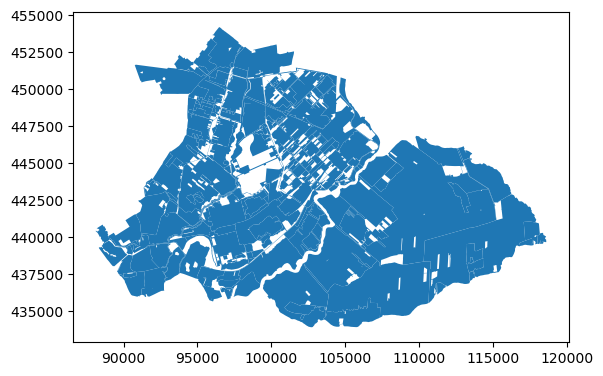

In [17]:
pgp_pw.plot()

In [18]:
pgv_diff = gpd.sjoin(left_df =  HHSK['peilgebiedvigerend'],
                     right_df = pgp_pw,
                     how = "inner",
                     predicate = 'intersects')

<AxesSubplot:>

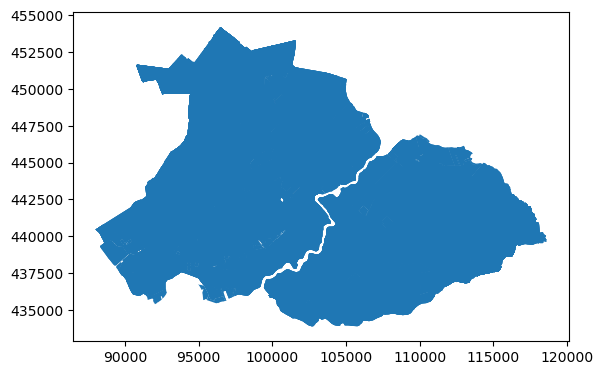

In [19]:
pgv_diff.plot()

In [20]:
# streefpeilen_PG_v = pd.merge(left = HHSK['peilgebiedvigerend'],
#                              right = HHSK['streefpeil'],
#                              left_on = 'globalid',
#                              right_on = 'peilgebiedvigerendid',
#                              suffixes = ('', '_streefpeil'))[['code', 'nen3610id', 'globalid', 'waterhoogte', 'geometry']]

# streefpeilen_PG_a = pd.merge(left = HHSK['peilafwijkinggebied'],
#                              right = HHSK['streefpeil'],
#                              left_on = 'globalid',
#                              right_on = 'peilafwijkinggebiedid',
#                              suffixes = ('', '_streefpeil'))[['code', 'nen3610id', 'globalid', 'waterhoogte', 'geometry']]

# fig, ax = plt.subplots()
# streefpeilen_PG_v.plot(ax = ax, color='cornflowerblue')
# streefpeilen_PG_a.plot(ax = ax, color='blue')

In [21]:
# streefpeilen_PG_v.to_file('vigerend.shp')
# streefpeilen_PG_a.to_file('afwijking.shp')

In [23]:
# peilgebied = burn_in_peilgebieden(base_layer = streefpeilen_PG_v, 
#                                   overlay_layer = streefpeilen_PG_a,
#                                   plot = True)

In [24]:
streefpeil = gpd.GeoDataFrame()
streefpeil['waterhoogte'] = peilgebied['waterhoogte']
streefpeil['globalid'] = peilgebied['globalid']
streefpeil['geometry'] = np.nan
HHSK['streefpeil'] = gpd.GeoDataFrame(streefpeil)

NameError: name 'peilgebied' is not defined

In [ ]:
HHSK['peilgebied'] = gpd.GeoDataFrame(peilgebied[['code', 'nen3610id', 'globalid', 'geometry']])

In [ ]:
HHSK['peilgebied'] = HHSK['peilgebied'].loc[HHSK['peilgebied']['code'] !='GPG-1206'] #Not a regular polygon

### Delete irrelevant data

In [ ]:
#delete irrelvant data
variables = ['peilgebiedpraktijk', 'peilgebiedvigerend', 'peilafwijkinggebied']

for variable in variables:
    if str(variable) in HHSK:
        del HHSK[variable]

In [26]:
#add duikersifonhevels to the hydroobjecten    
HHSK['hydroobject'] = pd.concat([HHSK['hydroobject'], HHSK['duikersifonhevel']])
HHSK['hydroobject'] = HHSK['hydroobject'].drop_duplicates(subset='globalid') #in case it is run multiple times
HHSK['hydroobject'] = gpd.GeoDataFrame(HHSK['hydroobject']).set_crs('epsg:28992')


### Check for the correct keys and columns

In [18]:
show_layers_and_columns(waterschap = HHSK)

stuw
['code' 'nen3610id' 'globalid' 'geometry']
type =  <class 'geopandas.geodataframe.GeoDataFrame'>
crs =  EPSG:28992

gemaal
['code' 'nen3610id' 'globalid' 'geometry']
type =  <class 'geopandas.geodataframe.GeoDataFrame'>
crs =  EPSG:28992

afsluitmiddel
['code' 'nen3610id' 'globalid' 'geometry']
type =  <class 'geopandas.geodataframe.GeoDataFrame'>
crs =  EPSG:28992

duikersifonhevel
['code' 'nen3610id' 'globalid' 'geometry']
type =  <class 'geopandas.geodataframe.GeoDataFrame'>
crs =  EPSG:28992

hydroobject
['code' 'nen3610id' 'globalid' 'geometry']
type =  <class 'geopandas.geodataframe.GeoDataFrame'>
crs =  EPSG:28992

streefpeil
['waterhoogte' 'globalid' 'geometry']
type =  <class 'geopandas.geodataframe.GeoDataFrame'>
crs =  None

peilgebied
['code' 'nen3610id' 'globalid' 'geometry']
type =  <class 'geopandas.geodataframe.GeoDataFrame'>
crs =  EPSG:28992



### Store data

In [19]:
# Check if the directory exists
if not os.path.exists(output_gpkg_path):
    # If it doesn't exist, create it
    os.makedirs(output_gpkg_path)
    
store_data(waterschap = HHSK, 
           output_gpkg_path = output_gpkg_path + '/HHSK')
